In [1]:
from functions import *
from random import sample
from htmldate import find_date
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup
import json
import os
from langid.langid import LanguageIdentifier, model
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
import re,langid
from purl import URL
import webbrowser

In [2]:
base_path = "/media/ruben/Data Drive/react-data/protest/carlo-batch-selection"

In [56]:
# Load Date Dictionary
dates_ref = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    with open(os.path.join(photo_folder,"dates.txt"),'r') as f:
        x = f.readlines()
    dates_ref.update({d.split('|')[0]:d.split('|')[-1].replace('\n','') for d in x if d.split('|')[-1].replace('\n','') != "na" and "ERROR" not in d.split('|')[-1].replace('\n','')})

# Load Language Dictionary
language_ref = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    
    with open(os.path.join(photo_folder,'languages-'+photo+".json"),'r') as f:
        lang = json.load(f)
    
    languages = []
    
    for iterkey,items1 in lang.items():
        
        for id_, lan_items in items1.items():
            language = lan_items[0]
            language_ref.update({id_:language})
            
# Load Categories
with open('/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_carlo/data-categories.json','r') as fp:
    category_ref = json.load(fp)
                
# Load Text Dictionary
text_ref = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    num_iterations = [fol for fol in os.listdir(photo_folder) if os.path.isdir(os.path.join(photo_folder,fol)) and "source" not in fol and "context" not in fol]
    num_iterations = len(num_iterations)

    start_iter = 1
    range_iter = [str(i) for i in list(range(1,num_iterations + 1))]

    folder_base = os.path.join(base_path,photo,photo)

    for iteration in range_iter:
        fn = os.path.join(folder_base + "_" +str(iteration),"txt", "parsed_text.json")
        with open(fn) as fp:
            pages = json.load(fp)
            
        for identifier,sentences in pages.items():
            
            sentences = [s.replace("\n","").lower() for s in sentences]
            sentences = [re.sub(' +', ' ', s) for s in sentences]

            url = identifier.split('html_')[-1]
            id_ = identifier.split('/html/')[1].split('.html_')[0]
            if url in dates_ref.keys():
                date = dates_ref[url]
            else:
                date = "na"
            
            text_ref.update({identifier:dict()})
            text_ref[identifier].update({"photo":photo,"url":url,"identifier":id_,"date":date,"language":language_ref[url],"topleveldomain":URL.from_string(url).domain(),"category":category_ref[URL.from_string(url).domain()],"sentences":"||".join(sentences)})

In [59]:
df = pd.DataFrame.from_dict(text_ref,orient='index').reset_index()
df.columns = ["path","photo","url","identifier","date","language","topleveldomain","category","sentences"]

In [60]:
df.to_csv('/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_carlo/data-full.csv',index=False)

In [20]:
list_years = list(set([i[0:4] for i in df['date'] if i != "na" and "ERR" not in i]))
list_cats = list(set([i for i in df['category']]))

In [27]:
pdf = []

for year in list_years:
    
    tmp = df[df['date'].astype(str).str[0:4] == year]
    
    catresults = [year]
    
    for cat in list_cats:
        catresults.append(len(tmp[tmp['category'] == cat]))
        
    pdf.append(catresults)

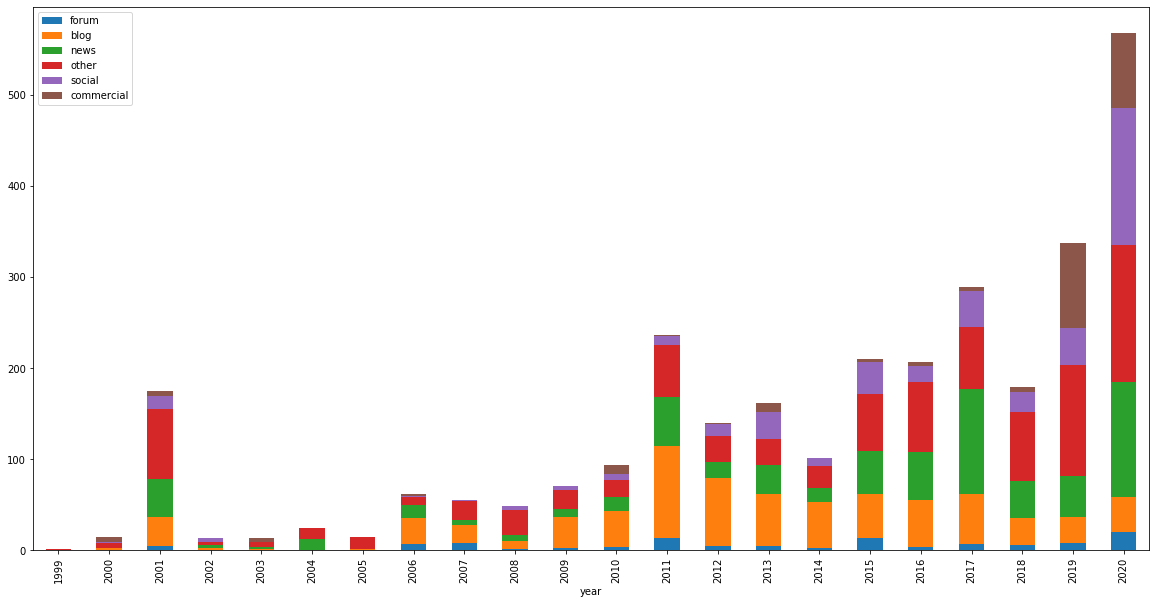

In [48]:
pdfp = pd.DataFrame(pdf,columns = ['year'] + list_cats).sort_values('year')
pdfp.plot.bar(x='year',y=list(pdfp.columns)[1:],stacked=True,figsize=(20,10))

In [49]:
pdfpr = pdfp.T
pdfpr.columns = pdfpr.iloc[0,:]
pdfpr = pdfpr.iloc[1:,:].reset_index()

In [50]:
for c in list(pdfpr.columns)[1:]:
    pdfpr[c] = [i / pdfpr[c].sum() for i in pdfpr[c]]

In [51]:
pdfpr = pdfpr.T
pdfpr.columns = pdfpr.iloc[0,:]
pdfpr = pdfpr.iloc[1:,:].reset_index()

In [52]:
pdfpr

index,year,forum,blog,news,other,social,commercial
0,1999,0,0,0,1,0,0
1,2000,0,0.2,0,0.333333,0.0666667,0.4
2,2001,0.0285714,0.182857,0.234286,0.44,0.08,0.0342857
3,2002,0,0.142857,0.285714,0.214286,0.357143,0
4,2003,0,0.0769231,0.230769,0.384615,0,0.307692
5,2004,0,0,0.48,0.52,0,0
6,2005,0,0.0666667,0,0.933333,0,0
7,2006,0.112903,0.451613,0.241935,0.129032,0.0322581,0.0322581
8,2007,0.145455,0.363636,0.0909091,0.381818,0.0181818,0
9,2008,0.0204082,0.183673,0.142857,0.55102,0.102041,0


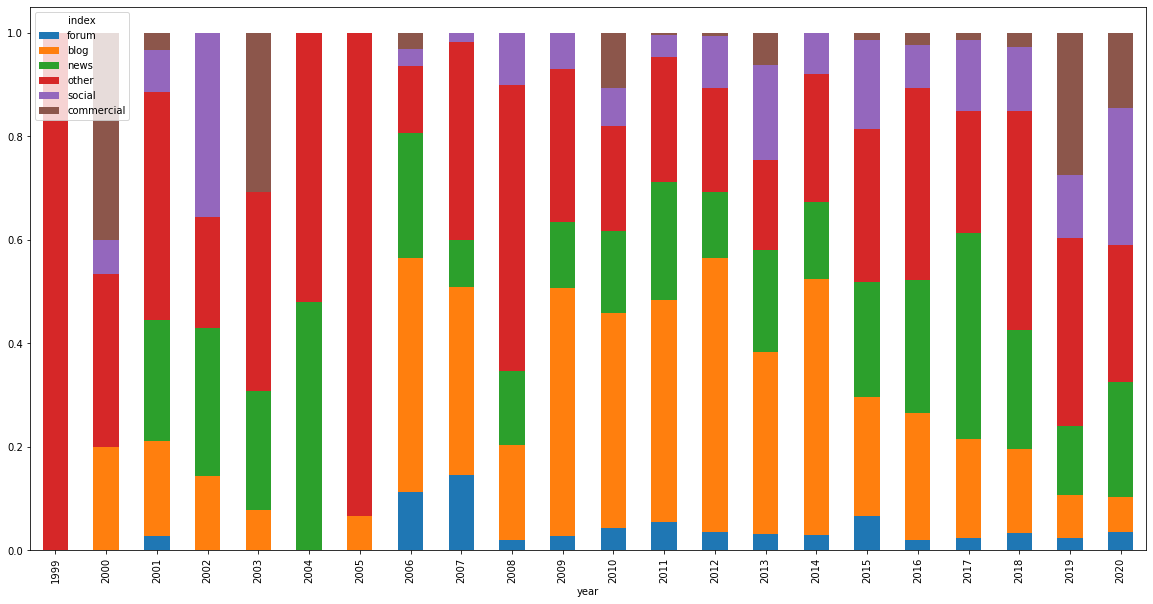

In [54]:
pdfpr.plot.bar(x='year',y=list(pdfpr.columns)[1:],stacked=True,figsize=(20,10))

In [74]:
# Open translation file
refdf = pd.read_csv("/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_carlo/descriptive-full.csv")
refdf = dict(zip(refdf['image'],refdf['pretty_title']))

df = pd.read_csv(open('/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_carlo/data-full.csv'), encoding='utf-8', engine='c')

In [75]:
df = df[['photo','category']]
df['n'] = 1
df = df.groupby(['photo','category']).sum().reset_index()
df = df.pivot(index='category',columns='photo',values='n').fillna(0)
df.columns = [str(int(c)) for c in df.columns]

In [76]:
freq_dict = {refdf[int(c)]:str(int(df[c].sum())) for c in list(df.columns)}

In [77]:
for c in df.columns:
    df[c] = [i/df[c].sum() for i in df[c]]
df = df.T.reset_index()

In [78]:
df['index'] = [refdf[int(c)] for c in list(df['index'])]

In [79]:
df = df.sort_values('blog',ascending=False)

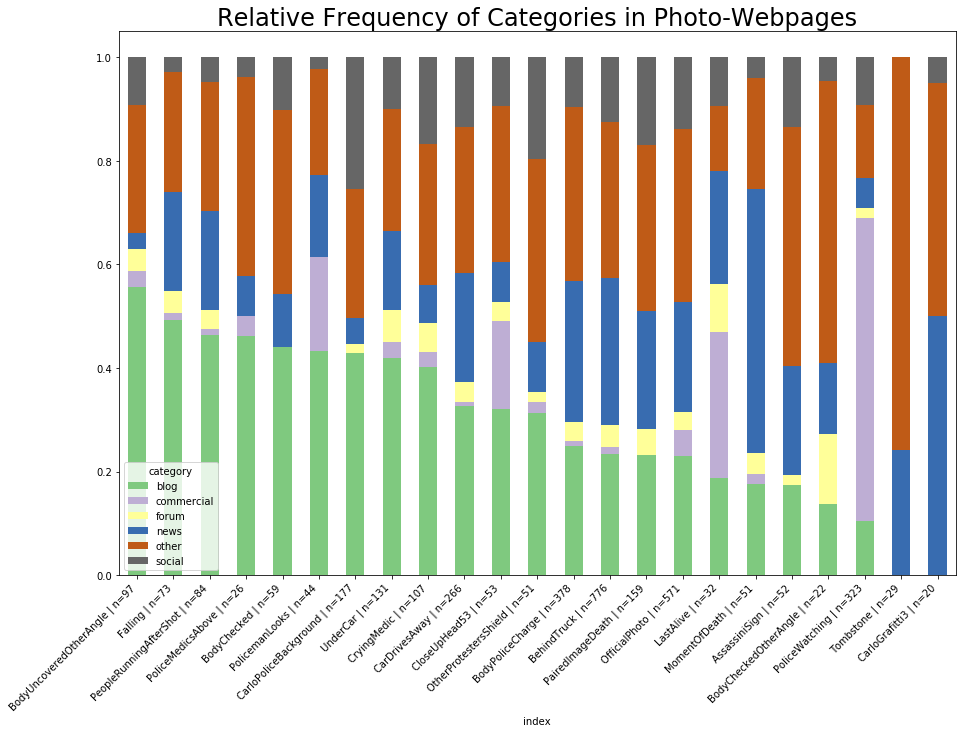

In [93]:
df.plot.bar(x='index',y=list(df.columns)[1:],figsize=(15,10),stacked=True, colormap='Accent')
locs, labels=plt.xticks()
x_ticks = []
new_xticks=[c + " | n=" + freq_dict[c] for c in df['index']]
plt.title('Relative Frequency of Categories in Photo-Webpages',size=24)
plt.savefig("/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_carlo/category-photo-frequency-relative.png",dpi=300, bbox_inches='tight')
plt.xticks(locs,new_xticks, rotation=45, horizontalalignment='right')
plt.show()

['BodyUncoveredOtherAngle | n=97',
 'Falling | n=73',
 'PeopleRunningAfterShot | n=84',
 'PoliceMedicsAbove | n=26',
 'BodyChecked | n=59',
 'PolicemanLooks | n=44',
 'CarloPoliceBackground | n=177',
 'UnderCar | n=131',
 'CryingMedic | n=107',
 'CarDrivesAway | n=266',
 'CloseUpHead53 | n=53',
 'OtherProtestersShield | n=51',
 'BodyPoliceCharge | n=378',
 'BehindTruck | n=776',
 'PairedImageDeath | n=159',
 'OfficialPhoto | n=571',
 'LastAlive | n=32',
 'MomentOfDeath | n=51',
 'AssassiniSign | n=52',
 'BodyCheckedOtherAngle | n=22',
 'PoliceWatching | n=323',
 'Tombstone | n=29',
 'CarloGrafitti3 | n=20']

ConversionError: Failed to convert value(s) to axis units: ['BodyUncoveredOtherAngle | n=97', 'Falling | n=73', 'PeopleRunningAfterShot | n=84', 'PoliceMedicsAbove | n=26', 'BodyChecked | n=59', 'PolicemanLooks | n=44', 'CarloPoliceBackground | n=177', 'UnderCar | n=131', 'CryingMedic | n=107', 'CarDrivesAway | n=266', 'CloseUpHead53 | n=53', 'OtherProtestersShield | n=51', 'BodyPoliceCharge | n=378', 'BehindTruck | n=776', 'PairedImageDeath | n=159', 'OfficialPhoto | n=571', 'LastAlive | n=32', 'MomentOfDeath | n=51', 'AssassiniSign | n=52', 'BodyCheckedOtherAngle | n=22', 'PoliceWatching | n=323', 'Tombstone | n=29', 'CarloGrafitti3 | n=20']

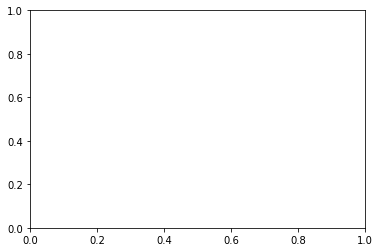